# Description

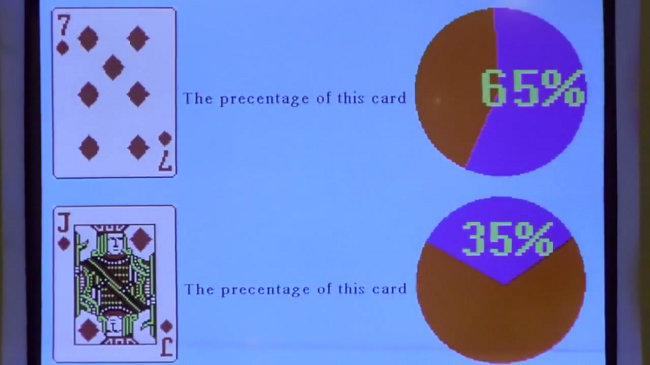

This Project was Inspired by God of Gamblers II (賭俠)

CNN Object Detection
Two Approaches: Transfer Learning Using YoloV3, Training My Own Network

The Dataset Has Already Been Split, Augmentated and Labelled

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pac
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Loading the Dataset

Download the Labelized Playing Cards Dataset

https://www.kaggle.com/hugopaigneau/playing-cards-dataset

In [35]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [36]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) API Token"

In [37]:
%cd /content/drive/My Drive/Colab Notebooks/Machine Learning Projects/Playing Card Object Detection/Dataset

/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/Playing Card Object Detection/Dataset


In [38]:
#!kaggle datasets download -d hugopaigneau/playing-cards-dataset

In [39]:
#!unzip 'playing-cards-dataset.zip'

In [128]:
train_cards_label = pd.read_csv('train_cards_label.csv')
test_cards_label = pd.read_csv('test_cards_label.csv')
cards_names = pd.read_csv('cards.names', header=None)

# Data Analysis and Visualization

The label document contains filename, dimension of the image, class (which card number) and the corresponding coordinates

In [136]:
train_cards_label.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,627194074.jpg,1080,1080,9s,82,724,147,752
1,627194074.jpg,1080,1080,Qc,85,584,153,640
2,627194074.jpg,1080,1080,2h,164,470,213,524
3,627194074.jpg,1080,1080,6s,276,380,315,443
4,627194074.jpg,1080,1080,Qd,395,342,433,409


There are 5000 images in the train set and 1000 images in the test set with 52 unique cards (label)

In [135]:
print('Train,', 'Test,', 'Unique Cards')
len(train_cards_label['filename'].unique()), len(test_cards_label['filename'].unique()), len(cards_names)

Train, Test, Unique Cards


(5000, 1000, 52)

<BarContainer object of 52 artists>

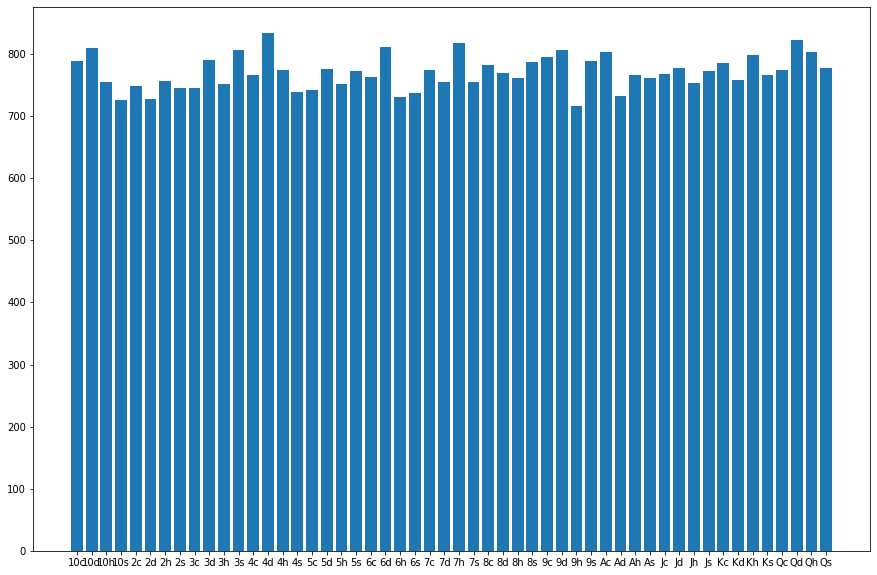

In [252]:
train_class_count = train_cards_label.groupby(by='class').count()
test_class_count = test_cards_label.groupby(by='class').count()
all_count = pd.DataFrame({'Train': train_class_count['filename'], 'Test': test_class_count['filename']})

fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(all_count.index, all_count['Train'])


We can also visualize the bounding boxes with randomly selected image from the train set

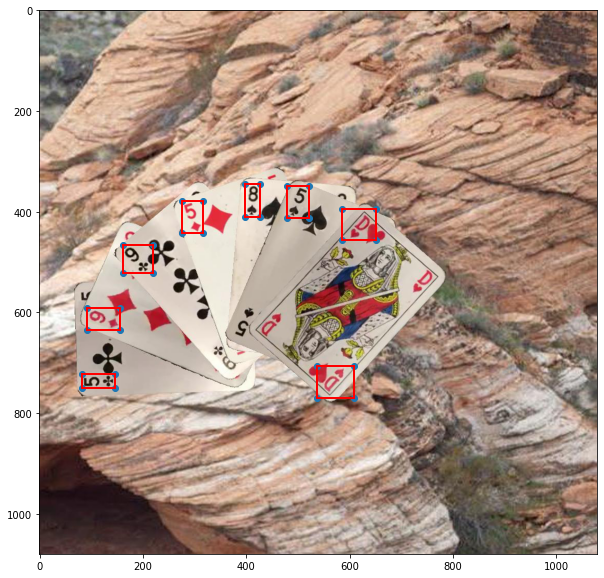

In [99]:
fig, ax = plt.subplots(figsize=(10, 10))
rand_train_cards = np.random.randint(len(train_cards_label))
random_train_img = train_cards_label.iloc[rand_train_cards]
img = plt.imread('train_zipped/' + random_train_img[0])

cards = train_cards_label[train_cards_label['filename'] == random_train_img[0]]
xmin, ymin, xmax, ymax = cards['xmin'], cards['ymin'], cards['xmax'], cards['ymax']

for i in cards.index:
  rect = pac.Rectangle((xmin[i], ymin[i]), xmax[i] - xmin[i], ymax[i] - ymin[i], 
                       fill=False, color='r', linewidth=2)
  plt.gca().add_patch(rect)

ax.scatter([xmin, xmax, xmin, xmax], [ymin, ymax, ymax, ymin])
ax.imshow(img, aspect='auto')


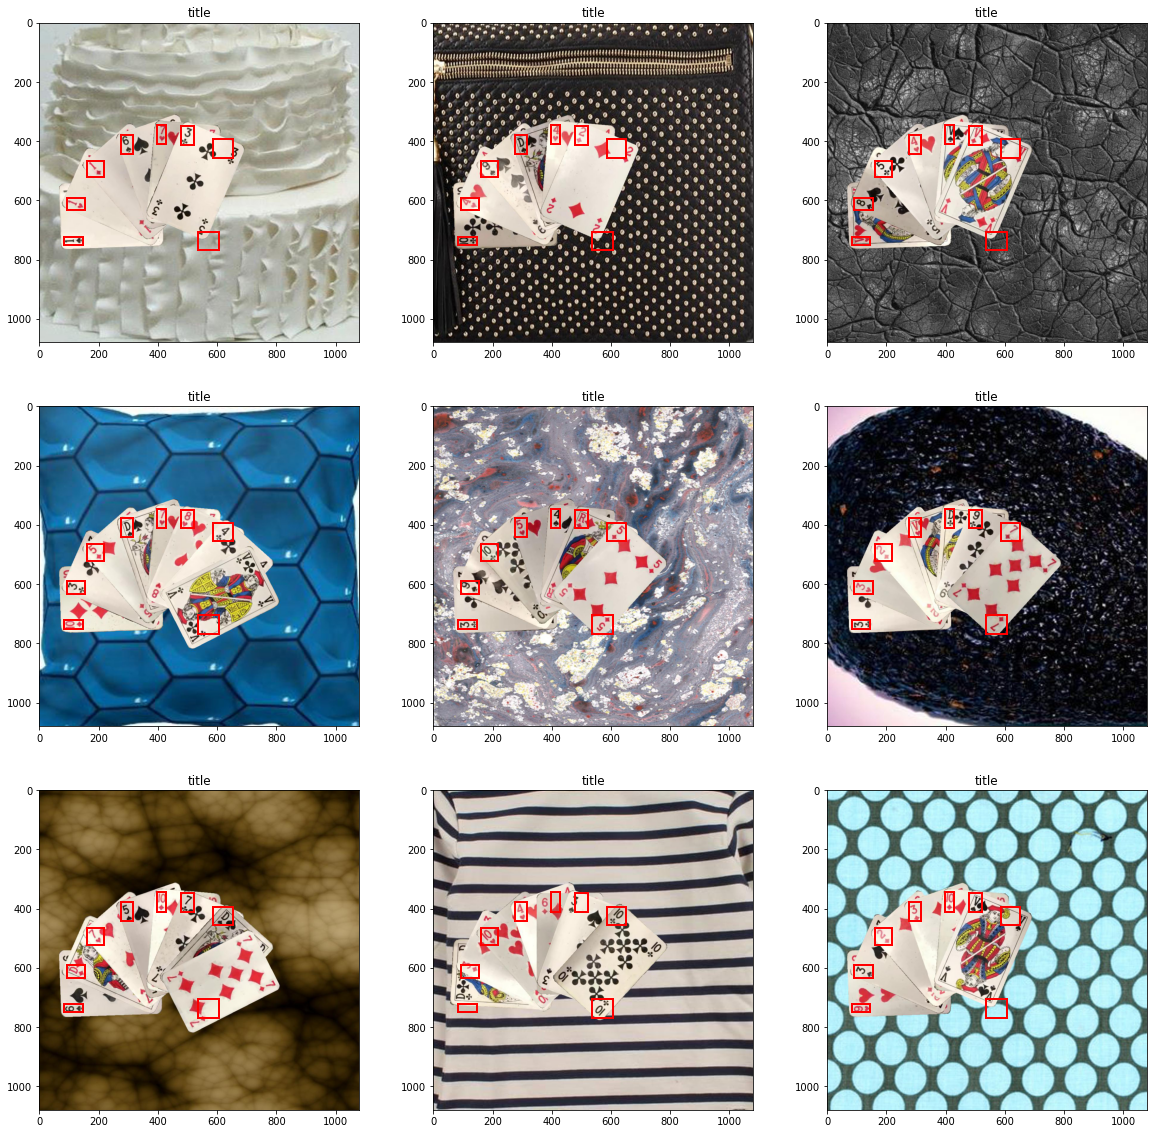

In [103]:
random_img_index = []
img_list = []
cards = train_cards_label[train_cards_label['filename'] == random_train_img[0]]
xmin, ymin, xmax, ymax = cards['xmin'], cards['ymin'], cards['xmax'], cards['ymax']

fig = plt.figure(figsize=(20, 20))

for i in range(9):
  n = np.random.randint(len(train_cards_label))
  random_img_index.append(n)

for i in random_img_index:
  img = plt.imread('train_zipped/' + train_cards_label.iloc[i][0])
  img_list.append(img)

for i in range(len(img_list)):
  fig.add_subplot(3, 3, i + 1)
  plt.gca().set_title('title')
  plt.imshow(img_list[i])
  #plt.scatter([xmin, xmax, xmin, xmax], [ymin, ymax, ymax, ymin])
  for i in cards.index:
    rect = pac.Rectangle((xmin[i], ymin[i]), xmax[i] - xmin[i], ymax[i] - ymin[i], 
                         fill=False, color='r', linewidth=2)
    plt.gca().add_patch(rect)

In [43]:
train_cards_label[train_cards_label['filename'] == random_train_img[0]]

,filename,width,height,class,xmin,ymin,xmax,ymax
18711,885004805.jpg,1080,1080,7h,85,723,148,750
18712,885004805.jpg,1080,1080,Jc,84,583,153,641
18713,885004805.jpg,1080,1080,Kc,156,460,221,531
18714,885004805.jpg,1080,1080,2s,276,379,317,445
18715,885004805.jpg,1080,1080,8h,399,343,428,406
18716,885004805.jpg,1080,1080,8h,480,351,519,411
18717,885004805.jpg,1080,1080,8h,532,659,572,721


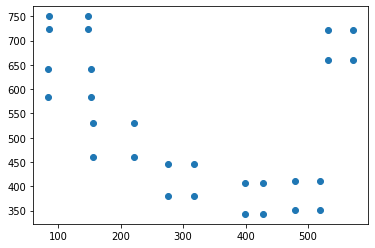

In [44]:
plt.scatter([xmin, xmax, xmin, xmax], [ymin, ymax, ymax, ymin])

Plotting Bounding Box

# Creating, Training CNN Model

## 1 Transfer Learning - YOLOv3

## 2 Building CNN

In [45]:
model = keras.models.Sequential([
  keras.layers.Conv2D(filters=20, kernel_size=8, strides=1, 
                      padding='Same', activation='relu', 
                      input_shape=(1080,1080,3)),
  keras.layers.MaxPooling2D((2, 2), strides=2),
  keras.layers.Conv2D(filters=20, kernel_size=8, strides=1,
                      padding='Same', activation='relu'),
  keras.layers.MaxPooling2D((2, 2), strides=4),
  keras.layers.Dropout(0.8),
  keras.layers.Dense(52) # 52 Different Cards
  # Output 52 Classes
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1080, 1080, 20)    3860      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 540, 540, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 540, 20)      25620     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 135, 135, 20)      0         
_________________________________________________________________
dropout (Dropout)            (None, 135, 135, 20)      0         
_________________________________________________________________
dense (Dense)                (None, 135, 135, 52)      1092      
Total params: 30,572
Trainable params: 30,572
Non-trainable params: 0
____________________________________________________

In [46]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')